### Import Library

In [32]:
import tensorflow as tf #type : ignore
from tensorflow.keras import layers # type: ignore 
 
from keras.preprocessing.image import ImageDataGenerator #type : ignore

import os
import shutil
import numpy as np #type : ignore

### Create train and test data folder, oversample the data, and split the data into train and test data

In [33]:
import random

def is_image_file(filename):
    """
    Check if a file is an image based on its extension.
    
    Args:
        filename (str): The name of the file.
        
    Returns:
        bool: True if the file is an image, False otherwise.
    """
    image_extensions = {'.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff'}
    return os.path.splitext(filename)[1].lower() in image_extensions

# Path to the original dataset directory
dataset_dir = r'D:/MSIB BANGKIT (6) 2024/Capstone/C_Project/Hiking_Dataset'

# Paths to the new train and test directories
train_dir = r'D:/MSIB BANGKIT (6) 2024/Capstone/C_Project/HikingDatasetTrain'
test_dir = r'D:/MSIB BANGKIT (6) 2024/Capstone/C_Project/HikingDatasetTest'

# Create the new train and test directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Iterate through each folder in the dataset directory
for folder in os.listdir(dataset_dir):
    folder_path = os.path.join(dataset_dir, folder)
    
    if not os.path.isdir(folder_path) or folder == ".DS_Store":
        continue

    # Paths for the corresponding train and test subdirectories
    train_subdir = os.path.join(train_dir, folder)
    test_subdir = os.path.join(test_dir, folder)

    # Create the train and test subdirectories
    os.makedirs(train_subdir, exist_ok=True)
    os.makedirs(test_subdir, exist_ok=True)

    # Get all image files in the folder
    image_files = [f for f in os.listdir(folder_path) if is_image_file(f)]

    # Shuffle the files to ensure random splitting
    random.shuffle(image_files)

    # Calculate split index
    split_index = int(len(image_files) * 0.8)

    # Split the files into train and test sets
    train_files = image_files[:split_index]
    test_files = image_files[split_index:]

    # Copy files to the train and test directories
    for file in train_files:
        src_file = os.path.join(folder_path, file)
        train_file = os.path.join(train_subdir, file)
        try:
            shutil.copy2(src_file, train_file)
        except Exception as e:
            pass  # Handle exceptions as needed

    for file in test_files:
        src_file = os.path.join(folder_path, file)
        test_file = os.path.join(test_subdir, file)
        try:
            shutil.copy2(src_file, test_file)
        except Exception as e:
            pass  # Handle exceptions as needed

### Rescale the image

In [34]:
img_height = 224
img_width = 224
batch_size = 32

### Define class

In [35]:
classes = os.listdir(train_dir)
classes = [c for c in classes if c != ".DS_Store"]
classes

['air mineral',
 'jaket gunung',
 'jas hujan',
 'kompor portable',
 'lampu senter',
 'sarung tangan gunung',
 'sepatu gunung',
 'sleeping bag',
 'tas gunung',
 'tenda',
 'tikar',
 'topi gunung']

### Data Augmentation

In [36]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.5, 1.5),
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Create a Keras DataGenerator with data augmentation
train_ds = datagen.flow_from_directory(
    train_dir,
    subset="training",
    seed=123,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    classes=classes
)

val_ds = datagen.flow_from_directory(
    train_dir,
    subset="validation",
    seed=123,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    classes=classes
)

Found 6721 images belonging to 12 classes.
Found 1676 images belonging to 12 classes.


In [37]:
test_datagen = ImageDataGenerator(
)

test_ds = datagen.flow_from_directory(
    test_dir, 
    seed=123,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    classes=classes

)

Found 2102 images belonging to 12 classes.


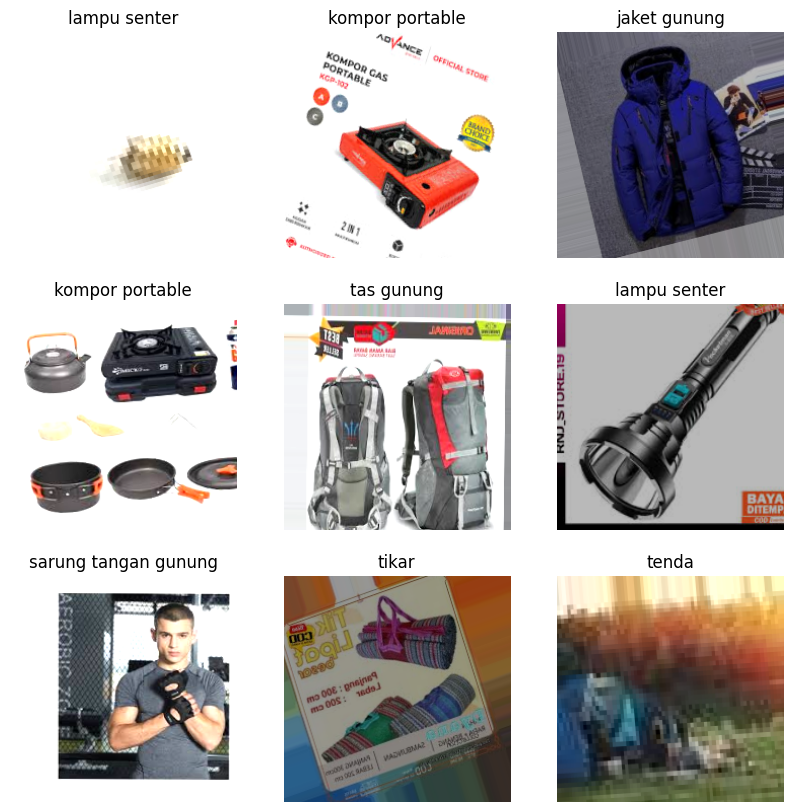

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].astype("uint8"))
        plt.title(classes[int(labels[i])])
        plt.axis("off")
    break

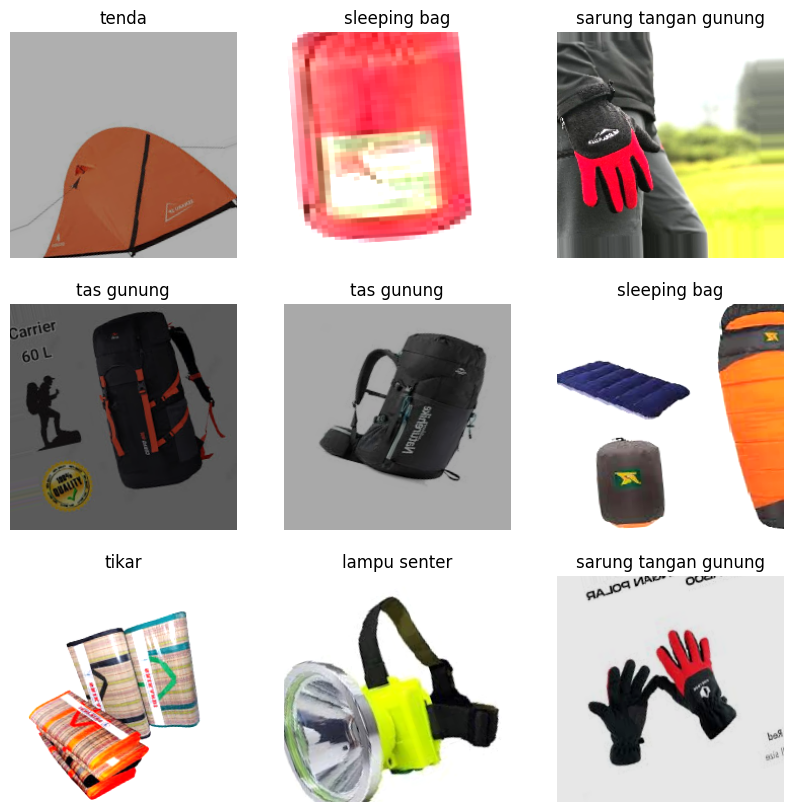

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in test_ds:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].astype("uint8"))
        plt.title(classes[int(labels[i])])
        plt.axis("off")
    break

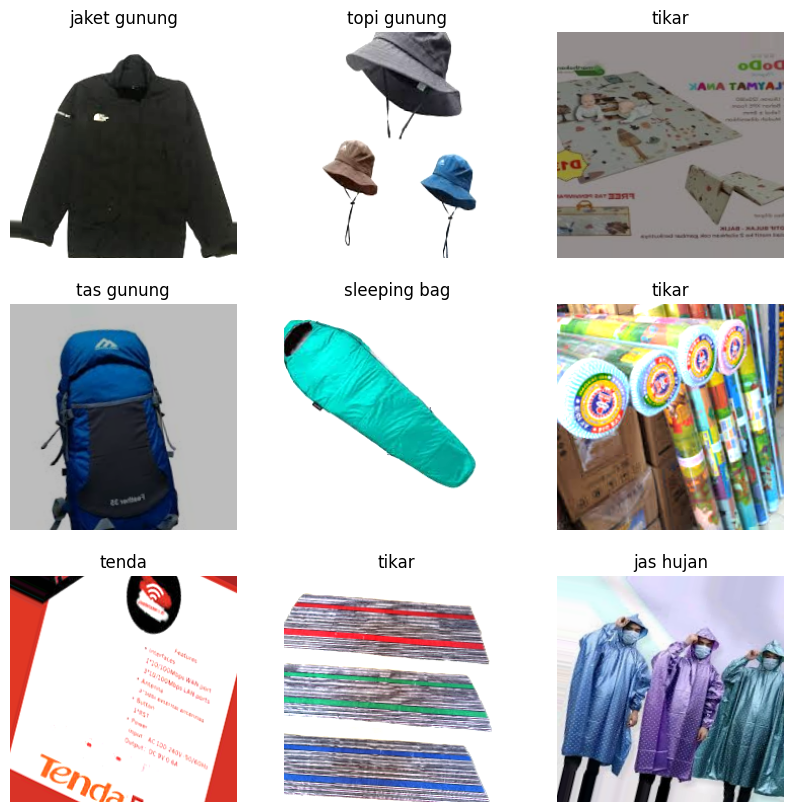

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in val_ds:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].astype("uint8"))
        plt.title(classes[int(labels[i])])
        plt.axis("off")
    break

### Model Building and Architecture Using ResNet50


In [41]:
from tensorflow.keras import layers, models, regularizers # type : ignore
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping # type : ignore

# Load ResNet50 model without the top layer and with average pooling
resnet = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg'
)

# Add a dense layer with L2 regularization and a dropout layer
x = resnet.output
x = layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.5)(x)  # Add Dropout layer with 50% rate
x = layers.BatchNormalization()(x)  # Add Batch Normalization

# Output layer
out = layers.Dense(len(classes), activation='softmax')(x)

# Create the final model
model = models.Model(inputs=resnet.input, outputs=out)

# Print the model summary
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_5[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

### Training Model

In [42]:
# Compile the model with Adam optimizer and sparse categorical cross-entropy loss
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Define callbacks including model checkpoint and early stopping
checkpoint_filepath = 'models/resnet50_best_model.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model with the callbacks
EPOCHS = 10
history = model.fit(train_ds, 
                    validation_data=val_ds, 
                    epochs=EPOCHS, 
                    callbacks=[model_checkpoint_callback, early_stopping_callback])

Epoch 1/10
211/211 [==============================] - 934s 4s/step - loss: 7.4844 - accuracy: 0.3748 - val_loss: 221.6227 - val_accuracy: 0.0805
Epoch 2/10
211/211 [==============================] - 848s 4s/step - loss: 2.4811 - accuracy: 0.5331 - val_loss: 2.5694 - val_accuracy: 0.3717
Epoch 3/10
211/211 [==============================] - 733s 3s/step - loss: 1.6987 - accuracy: 0.6416 - val_loss: 2.2158 - val_accuracy: 0.4511
Epoch 4/10
211/211 [==============================] - 735s 3s/step - loss: 1.3991 - accuracy: 0.6901 - val_loss: 1.4493 - val_accuracy: 0.6486
Epoch 5/10
211/211 [==============================] - 735s 3s/step - loss: 1.2349 - accuracy: 0.7236 - val_loss: 1.2297 - val_accuracy: 0.7178
Epoch 6/10
211/211 [==============================] - 758s 4s/step - loss: 1.1380 - accuracy: 0.7361 - val_loss: 1.8350 - val_accuracy: 0.5430
Epoch 7/10
211/211 [==============================] - 829s 4s/step - loss: 1.0797 - accuracy: 0.7558 - val_loss: 1.5250 - val_accuracy: 0.62

### Fine Tuning

In [43]:
# fine-tuning

for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), # Low learning rate
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[model_checkpoint_callback, early_stopping, reduce_lr])

Epoch 1/10


c:\Users\pozak\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


211/211 [==============================] - 810s 4s/step - loss: 0.7783 - accuracy: 0.8295 - val_loss: 0.6807 - val_accuracy: 0.8681 - lr: 1.0000e-05
Epoch 2/10
211/211 [==============================] - 735s 3s/step - loss: 0.6804 - accuracy: 0.8543 - val_loss: 0.6352 - val_accuracy: 0.8705 - lr: 1.0000e-05
Epoch 3/10
211/211 [==============================] - 735s 3s/step - loss: 0.6459 - accuracy: 0.8606 - val_loss: 0.5895 - val_accuracy: 0.8831 - lr: 1.0000e-05
Epoch 4/10
211/211 [==============================] - 742s 4s/step - loss: 0.5926 - accuracy: 0.8720 - val_loss: 0.5820 - val_accuracy: 0.8795 - lr: 1.0000e-05
Epoch 5/10
211/211 [==============================] - 788s 4s/step - loss: 0.5744 - accuracy: 0.8725 - val_loss: 0.5623 - val_accuracy: 0.8902 - lr: 1.0000e-05
Epoch 6/10
211/211 [==============================] - 806s 4s/step - loss: 0.5519 - accuracy: 0.8801 - val_loss: 0.5648 - val_accuracy: 0.8837 - lr: 1.0000e-05
Epoch 7/10
211/211 [==============================]

### Model Evaluation

Final Training Accuracy: 0.8836
Final Validation Accuracy: 0.8968
Final Training Loss: 0.4890
Final Validation Loss: 0.5216


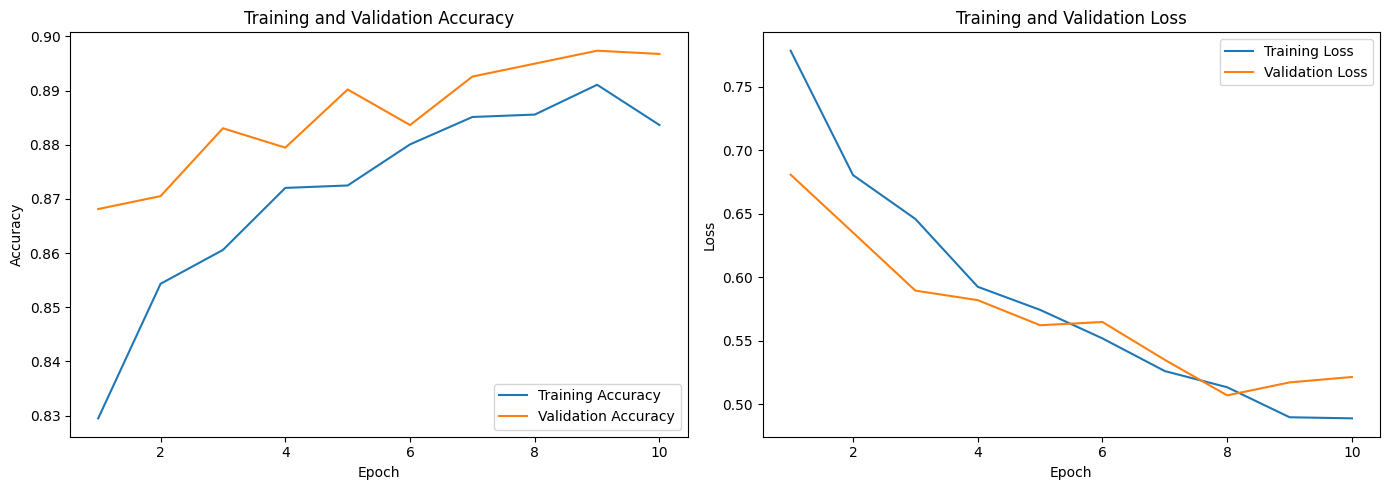

In [44]:
import matplotlib.pyplot as plt

# Ekstrak data dari objek history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

epochs_range = range(1, len(training_loss) + 1)

# Print metrics
print(f"Final Training Accuracy: {training_accuracy[-1]:.4f}")
print(f"Final Validation Accuracy: {validation_accuracy[-1]:.4f}")
print(f"Final Training Loss: {training_loss[-1]:.4f}")
print(f"Final Validation Loss: {validation_loss[-1]:.4f}")

# Plot training & validation accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

In [46]:
new_model = tf.keras.models.load_model('models/resnet50_best_model.h5')

In [47]:
new_model.evaluate(train_ds)
print("Train accuracy: ", new_model.evaluate(train_ds)[1])

211/211 [==============================] - 300s 1s/step - loss: 0.3902 - accuracy: 0.9182
Train accuracy:  0.9181669354438782


In [48]:
new_model.evaluate(val_ds)
print("Validation accuracy: ", new_model.evaluate(val_ds)[1])

53/53 [==============================] - 84s 2s/step - loss: 0.5063 - accuracy: 0.8998
Validation accuracy:  0.8997613191604614


In [49]:
new_model.evaluate(test_ds)
print("Test accuracy: ", new_model.evaluate(test_ds)[1])

66/66 [==============================] - 109s 2s/step - loss: 0.6048 - accuracy: 0.8587
Test accuracy:  0.858705997467041


### Confusion Matrix

In [50]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Generate predictions on the test set
predictions = model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)

# Get the true labels
true_labels = test_ds.classes

# Print the classification report
print(classification_report(true_labels, predicted_labels))

# Print the confusion matrix
print(confusion_matrix(true_labels, predicted_labels))

66/66 [==============================] - 112s 2s/step
              precision    recall  f1-score   support

           0       0.06      0.06      0.06       173
           1       0.06      0.06      0.06       192
           2       0.06      0.05      0.05       159
           3       0.11      0.10      0.11       129
           4       0.12      0.12      0.12       206
           5       0.09      0.09      0.09       174
           6       0.07      0.06      0.07       155
           7       0.07      0.07      0.07       172
           8       0.10      0.09      0.09       203
           9       0.08      0.08      0.08       189
          10       0.07      0.08      0.07       180
          11       0.08      0.08      0.08       170

    accuracy                           0.08      2102
   macro avg       0.08      0.08      0.08      2102
weighted avg       0.08      0.08      0.08      2102

[[11 15  8 13 20 16 17 16 11 19 13 14]
 [22 11 14 10 13 15 16 15 22 21 21 12]
 

### Save the model

In [51]:
model.save('resnet50FindtoFine.h5')
print('resnet50FindtoFine.h5')

c:\Users\pozak\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


resnet50FindtoFine.h5


In [52]:
# simpan dengan json
model_json = model.to_json()
with open("resnet50FindtoFine.json", "w") as json_file:
    json_file.write(model_json)
print('resnet50FindtoFine.json')

resnet50FindtoFine.json


In [53]:
# simpan dengan tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('resnet50FindtoFine.tflite', 'wb') as f:
    f.write(tflite_model)
print('resnet50FindtoFine.tflite')

INFO:tensorflow:Assets written to: C:\Users\pozak\AppData\Local\Temp\tmp5kf0562h\assets


INFO:tensorflow:Assets written to: C:\Users\pozak\AppData\Local\Temp\tmp5kf0562h\assets


resnet50FindtoFine.tflite
